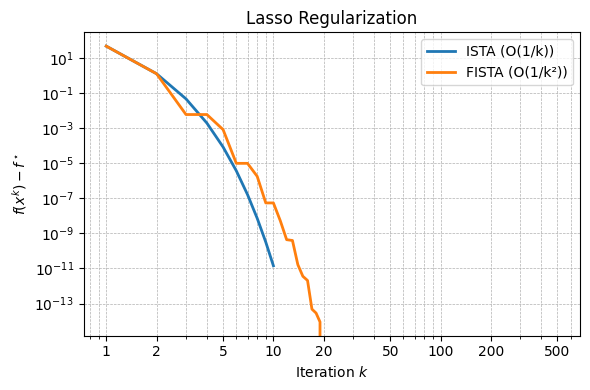

[LASSO] Skipped L-BFGS: L-BFGS only supports 'ridge' or 'elasticnet' (with alpha1 ≈ 0).


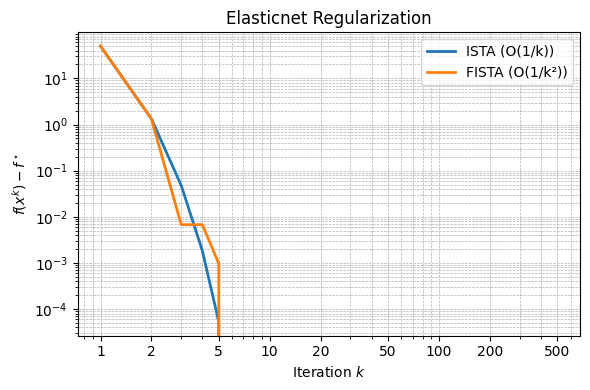

[ELASTICNET] Skipped L-BFGS: L-BFGS only supports smooth problems: alpha1 must be near 0.


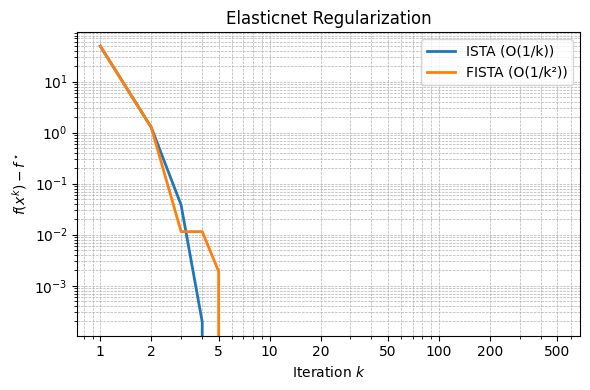

[ELASTICNET] Skipped L-BFGS: L-BFGS only supports smooth problems: alpha1 must be near 0.
[ELASTICNET] Skipped ISTA/FISTA: Unsupported reg_type: choose 'lasso' or 'elasticnet'
[RIDGE] Skipped ISTA/FISTA: unsupported reg_type
   method regularizer  alpha1  alpha2  n_iter    time_s   f_final  error_norm
0    ISTA       lasso  0.5000    0.00      10  0.002030  7.108271    9.371145
1   FISTA       lasso  0.5000    0.00     500  0.008931  7.108271    9.371146
2   Ridge       lasso  0.5000    0.00     500  0.008931  7.108271    9.371146
3    ISTA  elasticnet  0.2000    0.05      10  0.001104  5.749984    9.370875
4   FISTA  elasticnet  0.2000    0.05     500  0.008117  5.749984    9.370876
5   Ridge  elasticnet  0.2000    0.05     500  0.008117  5.749984    9.370876
6    ISTA  elasticnet  0.0001    0.50      10  0.000803  9.070438    9.371422
7   FISTA  elasticnet  0.0001    0.50     500  0.008070  9.070438    9.371422
8   Ridge  elasticnet  0.0001    0.50     500  0.008070  9.070438    9.37

In [69]:

# imports
from easy_boston_data import generate_easy_boston_like_data
from iterative_solvers import ista, fista
from lbfgs import LBFGSSolver
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

# 1) data gen + standardization
A, b, x_true = generate_easy_boston_like_data(m=800, seed=42, noise_std=0.1)
A_mean, A_std = A.mean(axis=0), A.std(axis=0)
A = (A - A_mean) / A_std
b = b - b.mean()

# 2) Lasso, Elastic-Net, Ridge
reg_settings = [
    {"name": "lasso",      "alpha1": 0.5,   "alpha2": 0.0},
    {"name": "elasticnet", "alpha1": 0.2,   "alpha2": 0.05},
    {"name": "elasticnet", "alpha1": 1e-4,  "alpha2": 0.5},
    {"name": "elasticnet", "alpha1": 0.0,   "alpha2": 0.5},
    {"name": "ridge",      "alpha1": 0.0,   "alpha2": 1.0}
]


records = []

for reg in reg_settings:
    name, a1, a2 = reg["name"], reg["alpha1"], reg["alpha2"]

    if name not in ("lasso", "elasticnet"):
        print(f"[{name.upper()}] Skipped ISTA/FISTA: unsupported reg_type")
        continue

    try:
        # ISTA
        t0 = time.perf_counter()
        x_ista, obj_ista = ista(A, b,
                                reg_type=name,
                                alpha1=a1,
                                alpha2=a2,
                                max_iter=500)
        t_ista = time.perf_counter() - t0

        # FISTA
        t0 = time.perf_counter()
        x_fista, obj_fista = fista(A, b,
                                   reg_type=name,
                                   alpha1=a1,
                                   alpha2=a2,
                                   max_iter=500)
        t_fista = time.perf_counter() - t0

        # approximate best f*
        f_star = obj_fista[-1]

        # --- compute the gaps ---
        gap_ista  = np.array(obj_ista)  - f_star
        gap_fista = np.array(obj_fista) - f_star

        # --- build envelope = running minimum (monotone decay) ---
        env_ista  = np.minimum.accumulate(gap_ista)
        env_fista = np.minimum.accumulate(gap_fista)

        # --- axis consistent with length of actual iterates ---
        ks_ista  = np.arange(1, len(env_ista) + 1)
        ks_fista = np.arange(1, len(env_fista) + 1)

        # --- plot envelopes only ---
        fig, ax = plt.subplots(figsize=(6, 4))
        ax.loglog(ks_ista, env_ista,  '-', label="ISTA (O(1/k))", linewidth=2)
        ax.loglog(ks_fista, env_fista, '-', label="FISTA (O(1/k²))", linewidth=2)

        ax.set_title(f"{name.title()} Regularization")
        ax.set_xlabel("Iteration $k$")
        ax.set_ylabel(r"$f(x^k)-f^\star$")
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.legend()

        from matplotlib.ticker import LogLocator, FormatStrFormatter
        ax.xaxis.set_major_locator(LogLocator(base=10, subs=[1, 2, 5]))
        ax.xaxis.set_minor_locator(LogLocator(base=10, subs=range(1, 10), numticks=12))
        ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

        plt.tight_layout()
        plt.show()

        records.append({
            "method":      "ISTA",
            "regularizer": name,
            "alpha1": a1,
            "alpha2": a2,
            "n_iter":      len(obj_ista),
            "time_s":      t_ista,
            "f_final":     obj_ista[-1],
            "error_norm":  np.linalg.norm(x_ista - x_true)
        })
        records.append({
            "method":      "FISTA",
            "regularizer": name,
            "alpha1": a1,
            "alpha2": a2,
            "n_iter":      len(obj_fista),
            "time_s":      t_fista,
            "f_final":     obj_fista[-1],
            "error_norm":  np.linalg.norm(x_fista - x_true)
        })
        
        records.append({
            "method": "Ridge",
            "regularizer": name,
            "alpha1": a1,
            "alpha2": a2,
            "n_iter": len(obj_fista),
            "time_s": t_fista,
            "f_final": obj_fista[-1],
            "error_norm":  np.linalg.norm(x_fista - x_true)
        })

    except ValueError as e:
        print(f"[{name.upper()}] Skipped ISTA/FISTA: {e}")


    # L-BFGS always attempted if valid
    try:
        solver = LBFGSSolver(reg_type=name, alpha1=a1, alpha2=a2)
        t0 = time.perf_counter()
        solver.fit(A, b)
        t_lbfgs = time.perf_counter() - t0

        records.append({
            "method":      "L-BFGS",
            "regularizer": name,
            "n_iter":      len(solver.history_),
            "time_s":      t_lbfgs,
            "f_final":     solver.final_obj_,
            "error_norm":  np.linalg.norm(solver.x_ - x_true)
        })

        # Plot convergence only for Ridge
        if name == "ridge":
            obj_vals = solver.history_
            f_star = solver.final_obj_
            gap_lbfgs = np.array(obj_vals) - f_star
            env_lbfgs = np.minimum.accumulate(gap_lbfgs)
            ks = np.arange(1, len(env_lbfgs)+1)

            fig, ax = plt.subplots(figsize=(6, 4))
            ax.loglog(ks, env_lbfgs, '-', label="L-BFGS", linewidth=2)
            ax.set_title("Ridge Regularization")
            ax.set_xlabel("Iteration $k$")
            ax.set_ylabel(r"$f(x^k)-f^\star$")
            ax.grid(True, which='both', linestyle='--', linewidth=0.5)
            ax.legend()

            from matplotlib.ticker import LogLocator, FormatStrFormatter
            ax.xaxis.set_major_locator(LogLocator(base=10, subs=[1,2,5]))
            ax.xaxis.set_minor_locator(LogLocator(base=10, subs=range(1,10), numticks=12))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))

            plt.tight_layout()
            plt.show()


    except ValueError as e:
        print(f"[{name.upper()}] Skipped L-BFGS: {e}")

# Final table
df_summary = pd.DataFrame(records)
print(df_summary)


Stats

In [70]:

opt_per_group = df_summary.groupby(["regularizer", "alpha1", "alpha2"])["f_final"].min().rename("f_opt")
df_final = df_summary.merge(opt_per_group, on=["regularizer", "alpha1", "alpha2"])
df_final["gap"] = df_final["f_final"] - df_final["f_opt"]
df_final["converged"] = df_final["gap"] < 1e-6
df_final


,method,regularizer,alpha1,alpha2,n_iter,time_s,f_final,error_norm,f_opt,gap,converged
0,ISTA,lasso,0.5000,0.00,10,0.002030,7.108271,9.371145,7.108271,1.429346e-11,True
1,FISTA,lasso,0.5000,0.00,500,0.008931,7.108271,9.371146,7.108271,0.000000e+00,True
2,Ridge,lasso,0.5000,0.00,500,0.008931,7.108271,9.371146,7.108271,0.000000e+00,True
3,ISTA,elasticnet,0.2000,0.05,10,0.001104,5.749984,9.370875,5.749984,0.000000e+00,True
4,FISTA,elasticnet,0.2000,0.05,500,0.008117,5.749984,9.370876,5.749984,1.216068e-08,True
5,Ridge,elasticnet,0.2000,0.05,500,0.008117,5.749984,9.370876,5.749984,1.216068e-08,True
6,ISTA,elasticnet,0.0001,0.50,10,0.000803,9.070438,9.371422,9.070438,0.000000e+00,True
7,FISTA,elasticnet,0.0001,0.50,500,0.008070,9.070438,9.371422,9.070438,1.210277e-07,True
8,Ridge,elasticnet,0.0001,0.50,500,0.008070,9.070438,9.371422,9.070438,1.210277e-07,True
